# Praca domowa nr 4
Author: Piotr Halama

In [1]:
import random
from copy import copy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import graphviz

from lightgbm import LGBMClassifier

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn_pandas import DataFrameMapper

##### Data

In [2]:
data = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

variables = ['w6_q21d_month', 'w6_q21d_year', 'w6_q25', 'w6_q26']

Chosen variables:
- w6_q21d_month - Month subject married partner
- w6_q21d_year - Year subject married partner
- w6_q25 - Did subject and partner attend same high school?
- w6_q26 - Did subject and partner attend same college?

Target variable: S1 - Are you married?

##### Preprocessing

In [3]:
X = data[variables]
y = data['S1']

X = X[pd.notnull(y)]
y = y[pd.notnull(y)]

months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

X['w6_q21d_month'] = X['w6_q21d_month'].astype('category').cat.set_categories(
    months, ordered=True)

X['w6_q25'] = X['w6_q25'].astype('category').cat.as_unordered()
X['w6_q26'] = X['w6_q26'].astype('category').cat.set_categories(
    ['Refused', 'Same College', 'Different College'],
    rename=True,
    ordered=False)
y = y.astype('category')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

##### Model

The classifier used here is based on gradient boosting from `LightGBM` package.

In [4]:
clf = LGBMClassifier(reg_alpha=0.5)
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.5, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [5]:
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, pos_label='Yes, I am Married')

0.963855421686747

## Homework solution

Selected observation:
- Month subject married partner - **July**
- Year subject married partner - **1991**
- Did subject and partner attend same high school? - **No**
- Did subject and partner attend same college? - **No**
- Are you married? - **Yes**

In [6]:
x = X.iloc[1736].to_dict()

### Generation of new dataset

In [7]:
N = 1000
z = []

for i in range(N):
    x_prim = copy(x)
    
    k = random.randrange(1, len(variables))  # How many variables to change
    for var in random.sample(variables, k):  # Choose variables
        if random.random() > 0.5:  # Clear value
            x_prim[var] = None
        elif isinstance(x_prim[var], str):  # categorical
            x_prim[var] = random.choice(X[var].cat.categories)
        else:  # numerical
            x_prim[var] += int(random.gauss(0, 3))
            
    z.append(x_prim)
        
z = pd.DataFrame(z)
z['w6_q21d_month'] = z['w6_q21d_month'].astype('category').cat.set_categories(
    months, ordered=True)
z['w6_q25'] = z['w6_q25'].astype('category').cat.as_unordered()
z['w6_q26'] = z['w6_q26'].astype('category').cat.as_unordered()

In [8]:
v = clf.predict(z)

### Whitebox model

In [9]:
whitebox = DecisionTreeClassifier(max_depth=3)

In [10]:
mapper = DataFrameMapper([('w6_q21d_year', None),
                          ('w6_q21d_month', LabelBinarizer()),
                          ('w6_q25', LabelBinarizer()),
                          ('w6_q26', LabelBinarizer())])

In [11]:
z.loc[pd.isnull(z['w6_q21d_year']), 'w6_q21d_year'] = x['w6_q21d_year']
z['w6_q21d_month'] = z['w6_q21d_month'].astype('str')
z['w6_q25'] = z['w6_q25'].astype('str')
z['w6_q26'] = z['w6_q26'].astype('str')

In [12]:
zm = mapper.fit_transform(z)
xm = mapper.transform(pd.DataFrame([x]))
vm = (v == 'Yes, I am Married')

In [13]:
# Similarity
sim = np.linalg.norm(zm - xm, 2, axis=1)
sim = max(sim) - sim

In [14]:
whitebox.fit(zm, vm, sample_weight=sim)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Visualization

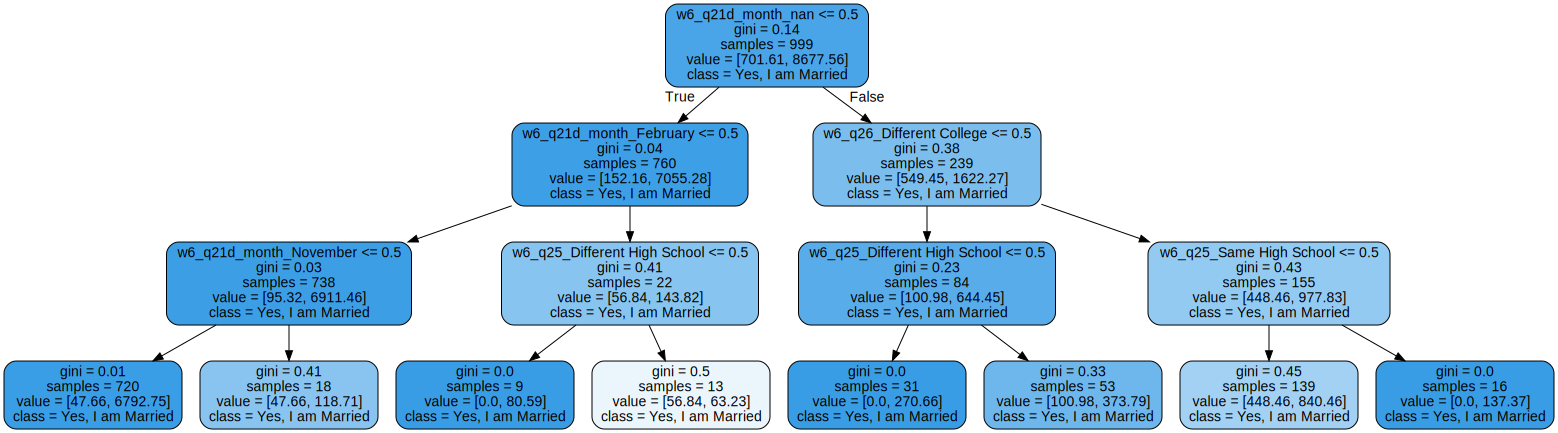

In [15]:
graphviz.Source(export_graphviz(
    whitebox,
    feature_names=mapper.transformed_names_,
    class_names=['No, I am not Married', 'Yes, I am Married'],
    rounded=True,
    proportion=False,
    precision=2,
    filled=True), format='png')

## Conclusion

Observations that one could make about the model:
  - Marrying in unusual months (February, November) lessens the chances of the subject being married.
  - Answer to the question 26 is more important than to the question 25: Have you been going to the same college/high school (respectively)?
  - The year of marriage is the least important.